# <font color = darkblue> Bem-vindo/a!

Este estudo foi desenvolvido pelos alunos

* Afonso Coelho (FCUP_IACD:202305085)

* Diogo Amaral (FCUP_IACD:202305187)

* Miguel Carvalho (FCUP_IACD:202305229)

no âmbito programático da Licenciatura em Inteligência Artifical e Ciência de Dados (L:IACD), em colaboração com as Faculdades de Ciências e Engenharia da Universidade do Porto (FCUP/FEUP).

### <font color = darkblue> Índice:

1. [Introdução à análise:](#intro) <br> 
    >1.1 [Contexto do problema](#contexto) <br>
    >1.2 [Expectativas e objetivos](#expect) <br>
    
2. [Inicialização do dataset](#init)

3. [Estatísticas descritivas báscias:](#estatisticas) <br>
    >3.1 [Média](#media) <br>
    >3.2 [Mediana](#mediana) <br>
    >3.3 [Desvio](#desvio) <br>
    >3.4 [Assimetria](#assimetria) <br>
    >3.5 [Curtose](#curtose) <br>
    
4. [Relotório de Análise - DataPrep](#relatorio) <br>

5. [Inputação dos missing values:](#missing-values) <br>
    >5.1 [Identificação visual dos missing values](#visual-missing-values) <br>
    >5.2 [Heterogeneous Euclidean-Overlap Metric para medir distâncias entre pacientes](#heom) <br>
    >5.3 [Inputação de missing values por HEOM](#heom-missing-values) <br>

6. [Ajuste de Outliers](#outliers) <br>
    >6.1 [Identificação visual dos outliers](#visual-outliers) <br>
    >6.2 [HEOM para enquadramento de far outliers](#heom-outliers) <br>

7. [K-Nearest Neighbors (KNN)](#knn) <br>
    >7.1 [Import de bibliotecas e inicialização de classes](#knn-class) <br>
    >7.2 [Separeção train/test e fitting do algoritmo](#knn-fit) <br>
    >7.3 [Accuracy e precision do algoritmo](#knn-acc) <br>

8. [Decision Tree](#tree) <br>
    >8.1 [Import de bibliotecas e inicialização de classes](#tree-class) <br>
    >8.2 [Separeção train/test e fitting do algoritmo](#tree-fit) <br>
    >8.3 [Visualização da tree criada](#tree-visual) <br>
    >8.4 [Accuracy e precision do algoritmo](#tree-acc) <br>

9. [Logistic Regression](#log) <br>
    >9.1 [Import de bibliotecas e inicialização de classes](#log-class) <br>
    >9.2 [Separeção train/test e fitting do algoritmo](#log-fit) <br>
    >9.3 [Accuracy e precision do algoritmo](#log-acc) <br>

10. [Random Forest](#forest)
    >10.1 [Import de bibliotecas e inicialização de classes](#forest-class) <br>
    >10.2 [Separeção train/test e fitting do algoritmo](#forest-fit) <br>
    >10.3 [Accuracy e precision do algoritmo](#forest-acc) <br>

# <font color = darkblue> 1. Introdução à análise <a class="anchor" id="intro"></a>

### <font color = blue> 1.1 Contexto do problema <a class="anchor" id="contexto"></a>

O projeto em mãos consiste na análise de um caso real do conjunto de dados representativo de pacientes que sofrem de Carcinoma Hepatocelular (HCC), mais comumente conhecido como cancro do fígado. O conjunto mencionado de dados HCC ([hcc_dataset.csv](hcc_dataset.csv)) foi recolhido no Centro Hospitalar e Universitário de Coimbra (CHUC) em Portugal, e contém dados clínicos reais de pacientes diagnosticados com HCC.

### <font color = blue> 1.2 Expectativas e objetivos <a class="anchor" id="expect"></a>

Pretende-se, portanto, desenvolver vários algoritmos SML (Supervised Machine Learning), capazes de classificar os pacientes relativamente à sua sobrevivência após 1 ano do diagnóstico (aspeto identificado na coluna `"Class"` com `"Lives"` ou `"Dies"`).

# <font color = darkblue> 2. Inicialização do dataset <a class="anchor" id="init"></a>

De modo a simplificar os restantes blocos de código, achamos por bem implementar uma classe `Dataset` e tratar o dataset [`hcc_dataset.csv`](hcc_dataset.csv) como um objeto dessa classe. Assim, operar sobre o dataset torna-se mais intuitivo e o codigo associado mais legível.

In [1]:
import pandas as pd
import numpy as np
import heapq
class Dataset:
    def __init__(self, df, missing_values):
        self.df = df
        self.missing_values = missing_values


    def pintarMissingValues(self):#pintar a tabela de missing values
        if self.missing_values is not None:#se existirem missing values
            self.df.replace(self.missing_values, "NaN", inplace=True)#substituir missing values por string "NaN" devido a limitação do site 
            return self.df.style.applymap(lambda valor: "color: red;" if valor=="NaN" else "")#pintar missing values a vermelho
        else: return self.df #se não existirem missing values


    def missing_values_percentagem(self):#Percentagem de missing values
        self.df.replace(self.missing_values, np.nan, inplace=True)#substituir missing values por NaN e nao string "NaN"
        missing_values_percentages = self.df.isnull().mean() * 100#calcular a percentagem de missing values
        return missing_values_percentages.tolist()#retornar a percentagem de missing values
    
    
    def remove_int_columns(self):
        df_copy = self.df.copy()  # create a copy of the dataframe
        numerical=self.df_num()
        common_columns = set(self.df.columns) & set(numerical.columns)
        df_copy = df_copy.drop(common_columns, axis=1)
        
        return df_copy
    

    def df_num(self):
        # Replace missing values with None
        dataframe= self.replace_nan_with_none()

        # Convert all columns to numeric, replacing non-numeric values with NaN
        for col in dataframe.columns:
            dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')

        # Remove columns that only contain None values
        self.df = dataframe.dropna(axis=1, how='all')

        return self.df


    def replace_nan_with_none(self):
        self.df.replace(self.missing_values, None, inplace=True)
        return self.df


    def pintarOutliers(self, df, outliers):
        def highlight_value(series, column):#Pintar as células que são outliers de azul
            return ['background-color: blue' if (column, index) in outliers else '' for index in series.index]
        return df.style.apply(lambda x: highlight_value(x, x.name), axis=0)#Aplicar a função a cada coluna
    

    def tabelaHEOM(self):
        self.df = self.replace_nan_with_none()#Trocar missing values para none
        tabela = pd.DataFrame()
        for i in range(len(self.df)):
            lista = []
            for j in range(len(self.df)):#Não interessa comparar pares de pacientes duas vezes
                if i >= j:
                    lista.append("X")# colocar x por motivos estéticos
                else:
                    lista.append(self.HEOM(i, j))# lista de um paciente em calculo HEOM

            tabela = pd.concat([tabela, pd.DataFrame({i: lista})], axis=1)#adicionar a lista à tabela
        return tabela
    

    def HEOM(self, paciente_1, paciente_2): #Heterogeneous Euclidean-Overlap Metric
        soma = 0
        for feature in self.df.columns:# iterar sobre as V
            distancia = self.distanciaGeral(feature, paciente_1, paciente_2)# calcular a sua "distancia"
            soma += distancia**2
        soma= soma**(1/2)
        return soma
    

    def distanciaGeral(self, feature:str, paciente_1:int, paciente_2:int)->int:
        try :#Se a variavel for numerica vem para aqui
            #distancia normalizada
            valorPaciente_1 = float(self.df.loc[paciente_1, feature])
            valorPaciente_2 = float(self.df.loc[paciente_2, feature])
            numeric_feature = pd.to_numeric(self.df[feature], errors='coerce')
            return abs(valorPaciente_1 - valorPaciente_2) / (numeric_feature.max() - numeric_feature.min())# retornar a range 
        except :#Se a variavel for categorica vem para aqui
            valorPaciente_1 = self.df.loc[paciente_1, feature]
            valorPaciente_2 = self.df.loc[paciente_2, feature]
            if valorPaciente_1 == valorPaciente_2 and  not pd.isna(valorPaciente_1):#Se forem iguais e não forem missing values
                return 0
            else: 
                return 1
    

    def outliers(self,info:str,vizinhos=None)->pd.DataFrame:
        # Selecionar apenas as colunas numéricas
        categorical_features = self.remove_int_columns() 
        numeric_df = self.df_num()

        colunas_numericas = numeric_df.columns
        if info == 'style':
            outliers = set()
        for coluna in colunas_numericas:#calcular os outliers usando o IQR
            if info == 'tratamento':
                outliers = []
            q1 = numeric_df[coluna].quantile(0.25)
            q3 = numeric_df[coluna].quantile(0.75)
            iqr = q3 - q1
            limite_inferior = q1 - 1.5 * iqr
            limite_superior = q3 + 1.5 * iqr
            for index, value in numeric_df[coluna].items():#adicionar outliers ao set
                if value < limite_inferior or value > limite_superior:
                    if info == 'tratamento' and coluna not in ["Iron", "Sat", "Ferritin"]:
                        if self.df.loc[index, coluna] > limite_superior * 5 or self.df.loc[index, coluna] < limite_inferior * 5:
                            outliers.append((index, coluna))
                    elif info == 'style':
                        outliers.add((coluna, index))
            if info == 'tratamento':
                self.df= self.tratamentoOutliers(outliers, coluna,vizinhos)
        if info == 'style':
            # Apply styling to outliers
            styled_df = self.pintarOutliers(numeric_df, outliers)
            return styled_df
        if info == 'tratamento': 
            self.df = (pd.concat([categorical_features,self.df ], axis=1))
            return self.df
    
    
    def tratamentoOutliers(self, outliers, coluna,vizinhos):
        
        lista_valores = self.df[coluna].tolist()#todos os valores da coluna 
        contador = -1
        valores_out = [self.df.loc[index,coluna] for index,coluna in outliers]#valores dos outliers
        for valor_outlier in valores_out:# iterar por todos os outliers
            contador+=1
            outlier = valor_outlier
            dicionario_distancias = []
            for valor in lista_valores:

                if outlier != valor and valor not in valores_out and not pd.isna(valor):

                    distancia = self.HEOM(lista_valores.index(valor), lista_valores.index(outlier))#calcular a distancia entre o outlier e os outros valores
                    if len(dicionario_distancias) < vizinhos:
                        heapq.heappush(dicionario_distancias, (-distancia, valor))
                    else:
                        if -distancia > dicionario_distancias[0][0]:
                            heapq.heapreplace(dicionario_distancias, (-distancia, valor))

            k_proximos = [abs(item[1]) for item in dicionario_distancias]# selecionar os k vizinhos mais proximos
            
            media = sum(k_proximos)/len(k_proximos)
            self.df.loc[outliers[contador][0], coluna] = media
        return self.df


    def fill_missing_values(self, nr_vizinhos:int) -> pd.DataFrame:

        self.df = self.replace_nan_with_none() # Replace missing values with None 

        self.df = self.df.drop(['Iron', 'Sat', 'Ferritin'], axis=1)# Drop unnecessary columns
        df_copiada = self.df.copy()# Create a copy of the DataFrame

        for i in range(len(self.df)): # Iterate over each row
            row = self.df.iloc[i]
            
            if row.isnull().any():# Check if the row has any missing values
                closest_rows = self.linhas_mais_proximas(nr_vizinhos, i)# Get the indices of the closest rows
    
                for col in self.df.columns:# Iterate over each column
                    if pd.isnull(row[col]): # If the value is missing, replace it with the most common value or mean from the closest rows
                        df_copiada.loc[i, col] = self.subs_na_tabela(closest_rows, col,nr_vizinhos,i)
        return df_copiada
    

    def subs_na_tabela(self, closest_rows:list, col:int,vizinhos,i)->float | str :
        # Initialize values
        column_values = []

        for row_index in closest_rows:
            try:
                # Check the type of values
                value = float(self.df.loc[row_index, col])
            except:
                value = self.df.loc[row_index, col]

            if value is not None and not pd.isna(value):
                column_values.append(value)
        if len(column_values) == 0:

            return self.subs_na_tabela(self.linhas_mais_proximas(vizinhos+1,i), col,vizinhos+1,i)
        # Calculate the result based on the type of values
        if isinstance(column_values[0], str):

            # If values are strings, return the most frequent value
            return max(set(column_values), key=column_values.count)
        elif isinstance(column_values[0], (int, float)):

            # If values are numeric, return the mean
            return np.mean(column_values)
        

    def linhas_mais_proximas(self, vizinhos:int,i:int)->list: # Calculate the HEOM distance for each other row
       
        heom_values = []

        for j in range(len(self.df)):

            if j != i:
                heom_distance = self.HEOM(i, j)# Calculate the HEOM distance
                if len(heom_values) < vizinhos: # If we have less than 'vizinhos' distances, we add it to the heap

                    heapq.heappush(heom_values, (-heom_distance, j))
                else:
                    if -heom_distance > heom_values[0][0]: # If the current distance is smaller than the largest distance in the heap, we replace it
                        heapq.heapreplace(heom_values, (-heom_distance, j))
    
        # Get the rows with the smallest HEOM distance
        closest_rows = [item[1] for item in heom_values]

        return closest_rows
    

    def categorical_to_numerical(self):
        """
        _summary_: converts all categorical features to numerical values

        _conversion_dictionary_:
            Male -> 0
            Female -> 1
            No -> 0
            Yes -> 1
            Disabled -> 0
            Ambulatory -> 1
            Restricted -> 2
            Selfcare -> 3
            Active -> 4
            None -> 0
            Grade I/II -> 1
            Grade III/IV -> 2
            Mild -> 1
            Moderate/Severe -> 2
            Dies -> 0
            Lives -> 1
            
        """
        words = ("Male","Female","No","Yes","Disabled","Ambulatory",
                 "Restricted","Selfcare","Active","None","Grade I/II",
                 "Grade III/IV","Mild","Moderate/Severe","Dies","Lives")
        values = (0,1,0,1,0,1,2,3,4,0,1,2,1,2,0,1)
        self.df.replace(words, values, inplace=True)
        return self.df

    def polirTabela(self):
        k_neighbors = 3
        self.df = self.outliers('tratamento',k_neighbors)
        self.df = self.fill_missing_values(k_neighbors)
        self.df = self.categorical_to_numerical()
        return self.df

    @classmethod #este classmethod funciona como um construtor alternativo e construir um dataframe a partir de um arquivo cs

    def builderData(cls, df, missing_values): 
        try:
            if not isinstance(df, pd.DataFrame):# Handle DataFrame input directly
                df = pd.read_csv(df)
            df = df.copy()# Avoid modifying the original DataFrame
            return cls(df, missing_values)
        except (FileNotFoundError, pd.errors.ParserError):
            # Handle potential errors: file not found or parsing errors
            print(f"Erro: Não conseguiu ler a data de {df}.")
            raise

# <font color = darkblue> 3. Estatísticas descritivas básicas <a class="anchor" id="estatisticas"></a>

Abaixo, encontram-se as estatísticas descritivas básicas (média, mediana, desvio padrão, assimetria e curtose), calculadas separadamente por coluna, bem como o código escrito para as obter:  

### <font color = blue> 3.1. Média <a class="anchor" id="media"></a>

In [2]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.df_num() #chamar apenas colunas numericas
mean_table = data.df.mean().to_frame("Média") #calcular média
display(mean_table)

,Média
Age,64.690909


### <font color = blue> 3.2. Mediana <a class="anchor" id="mediana"></a>

In [5]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.df_num() #chamar apenas colunas numericas
median_table = data.df.median().to_frame("Mediana") #calcular mediana
display(median_table)

,Median
Age,66.00
Grams_day,75.00
Packs_year,0.00
INR,1.30
AFP,33.00
Hemoglobin,13.05
MCV,94.95
Leucocytes,7.20
Platelets,93000.00
Albumin,3.40


### <font color = blue> 3.3. Desvio Padrão <a class="anchor" id="desvio"></a>

In [6]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.df_num() #chamar apenas colunas numericas
std_table = data.df.std().to_frame("Desvio Padrão") #calcular desvio padrão
display(std_table)

,Desvio Padrão
Age,13.319534
Grams_day,76.277680
Packs_year,51.565130
INR,0.477816
AFP,149098.335581
Hemoglobin,2.145237
MCV,8.405846
Leucocytes,2909.106006
Platelets,107118.632481
Albumin,0.685132


### <font color = blue> 3.4. Assimetria <a class="anchor" id="assimetria"></a>

In [7]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.df_num() #chamar apenas colunas numericas
skew_table = data.df.skew().to_frame("Assimetria") #calcular assimetria
display(skew_table)

,Assimetria
Age,-0.779988
Grams_day,1.986666
Packs_year,7.886234
INR,3.587974
AFP,11.392308
Hemoglobin,-0.441710
MCV,-0.087315
Leucocytes,1.865177
Platelets,0.950930
Albumin,-0.102843


### <font color = blue> 3.5. Curtose <a class="anchor" id="curtose"></a>

In [8]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.df_num() #chamar apenas colunas numericas
kurtosis_table = data.df.kurtosis().to_frame("Curtose") #calcular curtose
display(kurtosis_table)

,Curtose
Age,0.846190
Grams_day,7.931784
Packs_year,74.241726
INR,18.965445
AFP,136.018560
Hemoglobin,0.402549
MCV,0.971063
Leucocytes,2.432640
Platelets,0.504059
Albumin,-0.699851


# <font color = darkblue> 4. Relatório DataPrep <a class="anchor" id="relatorio"></a>

Apesar da biblioteca `dataprep` aparentar não ser compatível com o resto do nosso ambiente (o `conda` retorna varios erros semelhantes a `Couldn't solve the environment`), conseguimos criar um report DataPrep num ambiente alternativo, no qual não tinhamos outras bibliotecas (necessárias para este notebook) instaladas. <br>

Assim sendo, e de modo a evitar um `ModuleNotFoundError`, por favor consultar o report feito no ficheiro [dataReport.html](dataReport.html). É expectável encontrar informações sobre:

* Percentagem de missing values;
* Estatísticas descritivas de todas as features;
* Distribuições de dados em ``Q-Q Plots`` e em ``BoxPlots``
* Interações entre 2 variáveis
* Correlações entre variáveis
* Outros possíveis pontos de interesse

In [4]:

from dataprep import create_report

def criar_e_exibir_relatorio(ficheiro):
    data_file = pd.read_csv(ficheiro, na_values='?')
    data_file.to_csv(ficheiro, index=False)
    return create_report(data_file).show_browser()
criar_e_exibir_relatorio("hcc_dataset.csv")


ModuleNotFoundError: No module named 'dataprep'

# <font color = darkblue> 5. Inputação dos missing values <a class="anchor" id="missing-values"></a>

Nenhum dataset está completamente tratado enquanto existam **Missing Values** (valores em falta). Isto porque, existem várias técnicas de imputação de missing values, e utilizando essas técnicas, obtém-se mais informação do que anteriormente de forma fiável, aumentando a amostra sem comprometer a sua autenticidade.

Neste caso em específico, quando deparados com um missing value, determinamos, através de uma distância HEOM (Heterogeneous Euclidean-Overlap Metric) quais os `k` pacientes mais próximos ao nosso paciente alvo, e calculamos a média da feature desses pacientes. Finalmente, substituimos o missing value por essa média, como demonstrado em [5.3](#heom-missing-values) e descrito na função `fill_missing_values()`

### <font color = blue> 5.1. Identificação visual dos missing values <a class="anchor" id="visual-missing-values"></a>

In [ ]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.pintarMissingValues()

### <font color = blue> 5.2. Heterogeneous Euclidean-Overlap Metric <a class="anchor" id="heom"></a>

In [9]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.tabelaHEOM()

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,X,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
1,5.299683,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
2,4.048287,5.915786,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
3,3.245281,5.343068,3.558409,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
4,3.683806,5.495465,2.698323,3.241517,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,4.379363,5.721385,4.636164,4.516116,4.314898,4.862136,4.360479,4.826378,4.910478,4.269307,...,5.068029,4.228015,4.727487,5.03952,5.009368,X,X,X,X,X
161,4.502504,5.657485,4.37538,4.19943,4.315775,4.268535,4.232149,4.26435,4.084648,4.218532,...,4.422596,4.287435,4.180138,4.412553,4.134199,4.853423,X,X,X,X
162,3.888074,5.771767,4.132832,3.896931,3.986662,4.441792,4.566333,4.305891,4.099607,4.280652,...,4.667334,4.785305,4.131191,4.281219,4.880023,4.808943,5.022344,X,X,X
163,4.773466,6.190742,4.322748,4.499781,4.572141,4.776376,4.668574,4.648151,4.933664,4.837719,...,4.583438,4.330263,4.759901,4.999361,4.448485,4.568358,4.938729,4.901204,X,X


### <font color = blue> 5.3 Inputação dos missing values por HEOM <a class="anchor" id="heom-missing-values"></a>

In [ ]:
data = Dataset.builderData("hcc_dataset.csv", "?")
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
data.fill_missing_values(3)

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Class
0,Male,No,Yes,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,No,No,No,Yes,No,No,No,No,Yes,67,137,15,Active,None,None,1.53,95,13.7,106.6,4.9,99,3.4,2.1,34,41,183,150,7.1,0.7,1,3.5,0.5,Lives
1,Female,No,No,No,No,No,Yes,Yes,No,Yes,Yes,No,No,Yes,No,No,No,Yes,No,No,No,No,Yes,62,0,0.0,Active,None,None,1.18,4.033333,13.466667,90.533333,4.933333,61667.236667,4.166667,0.966667,72.666667,66.0,123.333333,91.666667,7.9,0.836667,1,1.8,0.575,Lives
2,Male,No,Yes,Yes,No,Yes,No,Yes,No,Yes,No,No,No,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,78,50,50,Ambulatory,None,Mild,0.96,5.8,8.9,79.8,8.4,472,3.3,0.4,58,68,202,109,7,2.1,5,13,0.1,Lives
3,Male,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,No,No,Yes,No,No,No,No,No,No,No,Yes,Yes,77,40,30,Active,None,None,0.95,2440,13.4,97.1,9,279,3.7,0.4,16,64,94,174,8.1,1.11,2,15.7,0.2,Dies
4,Male,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,No,No,No,Yes,Yes,No,No,No,No,No,No,No,Yes,76,100,30,Active,None,None,0.94,49,14.3,95.1,6.4,199,4.1,0.7,147,306,173,109,6.9,1.8,1,9,0.15,Lives
5,Male,No,Yes,No,No,No,No,Yes,No,No,No,Yes,No,No,No,No,No,Yes,Yes,Yes,No,No,Yes,75,80.0,33.75,Restricted,None,Mild,1.58,110,13.4,91.5,5.4,85,3.4,3.5,91,122,242,396,5.6,0.9,1,10,1.4,Dies
6,Male,No,No,No,No,Yes,Yes,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Yes,49,0,0,Active,None,None,1.4,138.9,10.4,102,3.2,42000,2.35,2.72,119,183,143,211,7.3,0.8,5,2.6,2.19,Dies
7,Male,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,61,67.5,20,Selfcare,None,None,1.46,9860,10.8,92,3,58,3.1,3.2,79,108,184,300,7.1,0.52,2,9,1.3,Dies
8,Male,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,No,No,Yes,No,No,No,Yes,Yes,Yes,No,No,Yes,50,100,32,Restricted,None,Mild,3.14,8.8,11.9,107.5,4.9,70,1.9,3.3,26,59,115,63,6.1,0.59,1,6.4,1.2,Lives
9,Male,Yes,Yes,No,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,43,100,0,Active,None,None,1.12,1.8,11.8,87.8,5100,193000,4.2,0.5,71,45,256,303,7.1,0.59,1,9.3,0.7,Lives


# <font color = darkblue> 6. Ajuste dos outliers <a class="anchor" id="outliers"></a>

Também o ajuste de outliers é um passo essencial no tratamento de qualquer dataset. O equilíbrio, no entanto, é mais difícil de alcançar neste aspeto. Isto porque, como os outliers representam casos excecionais, ajustá-los para a norma, apesar de garantir maior fiabilidade dos dados, reduz largamente a variabilidade. Assim sendo, distinguimos dois tipos de outliers: **far** e **close**.

Propomos que um outlier seja considerado **far** quando se verifica a seguinte condição:

$$
\quad x < (Q1 - 1.5 \times \text{IQR}) \times 1.5 \quad \lor \quad x > Q3 + (1.5 \times \text{IQR}) \times 1.5
$$

Assim, quando um far outlier for identificado, será ajustado de forma semelhante aos missing values (ver [5.](#missing-values))

### <font color = blue> 6.1. Identificação visual dos outliers <a class="anchor" id="visual-outliers"></a>

In [ ]:
data = Dataset.builderData("hcc_dataset.csv", "?")
display(data.outliers('style'))

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin
0,67,137.000000,15.000000,1.530000,95.000000,13.700000,106.600000,4.900000,99.000000,3.400000,2.100000,34.000000,41.000000,183.000000,150.000000,7.100000,0.700000,1.000000,3.500000,0.500000,nan,nan,nan
1,62,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.800000,nan,nan,nan,nan
2,78,50.000000,50.000000,0.960000,5.800000,8.900000,79.800000,8.400000,472.000000,3.300000,0.400000,58.000000,68.000000,202.000000,109.000000,7.000000,2.100000,5.000000,13.000000,0.100000,28.000000,6.000000,16.000000
3,77,40.000000,30.000000,0.950000,2440.000000,13.400000,97.100000,9.000000,279.000000,3.700000,0.400000,16.000000,64.000000,94.000000,174.000000,8.100000,1.110000,2.000000,15.700000,0.200000,nan,nan,nan
4,76,100.000000,30.000000,0.940000,49.000000,14.300000,95.100000,6.400000,199.000000,4.100000,0.700000,147.000000,306.000000,173.000000,109.000000,6.900000,1.800000,1.000000,9.000000,nan,59.000000,15.000000,22.000000
5,75,nan,nan,1.580000,110.000000,13.400000,91.500000,5.400000,85.000000,3.400000,3.500000,91.000000,122.000000,242.000000,396.000000,5.600000,0.900000,1.000000,10.000000,1.400000,53.000000,22.000000,111.000000
6,49,0.000000,0.000000,1.400000,138.900000,10.400000,102.000000,3.200000,42000.000000,2.350000,2.720000,119.000000,183.000000,143.000000,211.000000,7.300000,0.800000,5.000000,2.600000,2.190000,171.000000,126.000000,1452.000000
7,61,nan,20.000000,1.460000,9860.000000,10.800000,92.000000,3.000000,58.000000,3.100000,3.200000,79.000000,108.000000,184.000000,300.000000,7.100000,0.520000,2.000000,9.000000,1.300000,42.000000,25.000000,706.000000
8,50,100.000000,32.000000,3.140000,8.800000,11.900000,107.500000,4.900000,70.000000,1.900000,3.300000,26.000000,59.000000,115.000000,63.000000,6.100000,0.590000,1.000000,6.400000,1.200000,85.000000,73.000000,982.000000
9,43,100.000000,0.000000,1.120000,1.800000,11.800000,87.800000,5100.000000,193000.000000,4.200000,0.500000,71.000000,45.000000,256.000000,303.000000,7.100000,0.590000,1.000000,9.300000,0.700000,nan,nan,nan


### <font color = blue> 6.2. HEOM para enquadramento de far outliers <a class="anchor" id="heom-outliers"></a>

In [ ]:
data = Dataset.builderData("hcc_dataset.csv", "?")
display(data.outliers('tratamento', 3))

>**Nota:** A partir deste ponto, antes de executar qualquer algoritmo, a tabela será tratada automaticamente através da função `polirTabela()`. Tal função pode ser encontrada na classe `Dataset` (ver [2.](#init)) 

# <font color = darkblue> 7. K-Nearest Neighbors (KNN) <a class="anchor" id="knn"></a>

### <font color = blue> 7.1. Import de bibliotecas e inicialização de classes <a class="anchor" id="knn-class"></a>

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.discriminant_analysis import StandardScaler

knn = KNeighborsClassifier(n_neighbors=2) #COMPLETAR VALORES OTIMOS
scaler = StandardScaler()

### <font color = blue> 7.2. Separação train/test e fitting do algoritmo <a class="anchor" id="knn-fit"></a>

In [17]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.polirTabela()
X = data.df.drop(columns=['Class']).dropna()
y = data.df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=456) #COMPLETAR VALORES OTIMOS
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

### <font color = blue> 7.3. Accuracy e precision do algoritmo <a class="anchor" id="knn-acc"></a>

In [18]:
acc = accuracy_score(y_test, knn.predict(X_test))
pre = precision_score(y_test, knn.predict(X_test))
print(f"Accuracy: {acc}, Precision: {pre}")

Accuracy: 0.6666666666666666, Precision: 0.5666666666666667


# <font color = darkblue> 8. Decision Tree <a class="anchor" id="tree"></a>

### <font color = blue> 8.1. Import de bibliotecas e inicialização de classes <a class="anchor" id="tree-class"></a>

In [15]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.discriminant_analysis import StandardScaler
clf = DecisionTreeClassifier(max_depth=9, min_samples_split=7, min_samples_leaf=1)
scaler = StandardScaler()

### <font color = blue> 8.2. Separação train/test e fitting do algoritmo <a class="anchor" id="tree-fit"></a>

In [16]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.polirTabela()
X = data.df.drop(columns=['Class']).dropna()
y = data.df['Class']
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=456)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=7)

### <font color = blue> 8.3. Visualização da tree criada <a class="anchor" id="tree-visual"></a>

Para além de executando o código que se encontra abaixo, o esquema da tree encontra-se também no seguinte ficheiro: [tree.png](tree.png)

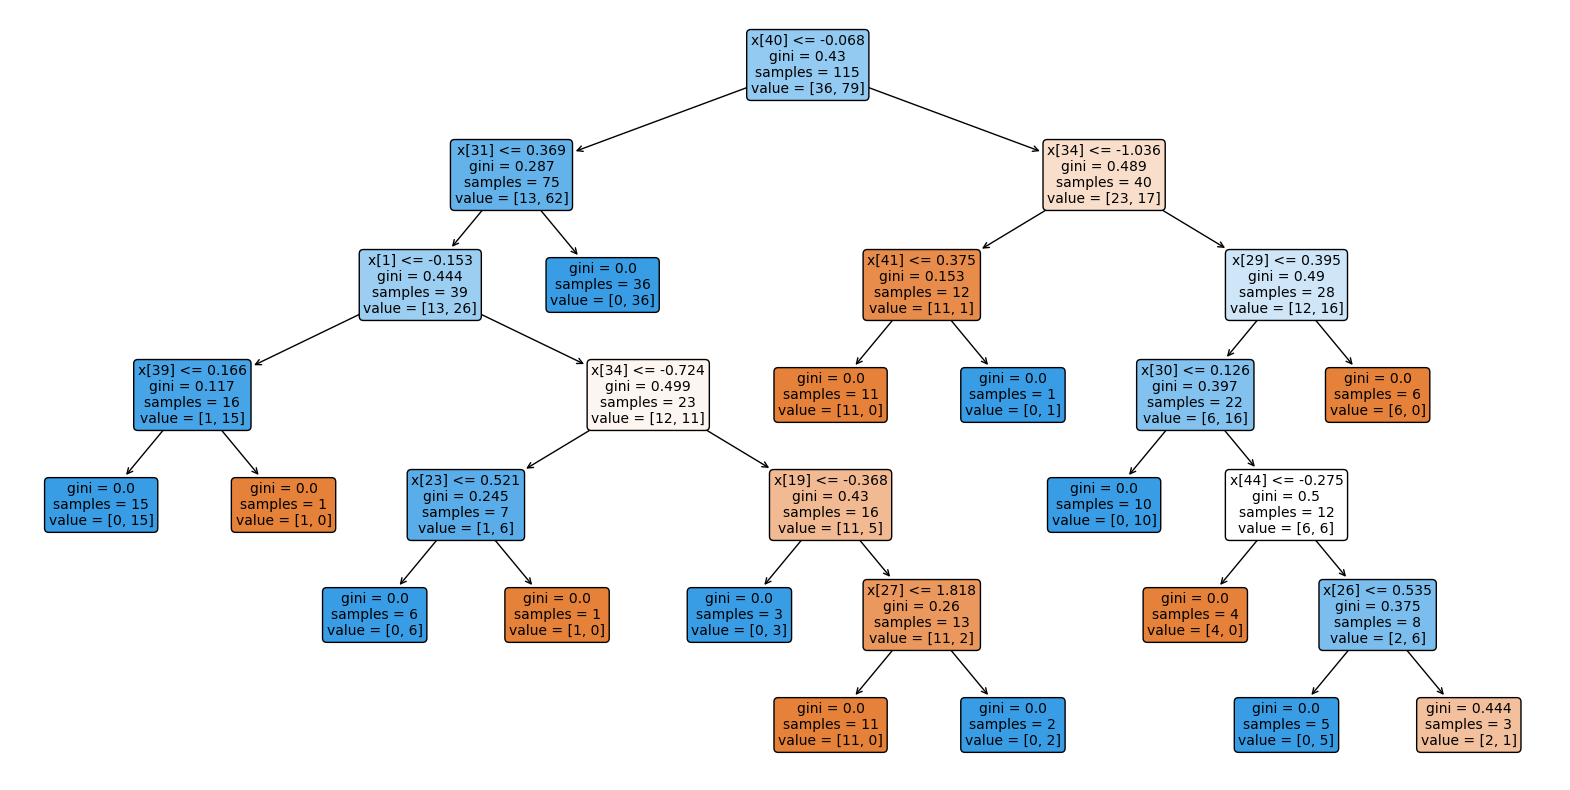

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))  # Adjust the figsize as per your preference
tree.plot_tree(clf, ax=ax, filled=True, rounded=True, fontsize=10)  # Increase the dpi value for higher resolution
plt.show()

### <font color = blue> 8.4. Accuracy e precision do algoritmo <a class="anchor" id="tree-acc"></a>

In [24]:
acc = accuracy_score(y_test, clf.predict(X_test))
pre = precision_score(y_test, clf.predict(X_test))
print(f"Accuracy: {acc}, Precision: {pre}")

Accuracy: 0.56, Precision: 0.5142857142857142


# <font color = darkblue> 9. Logistic Regression <a class="anchor" id="log"></a>

### <font color = blue> 9.1. Import de bibliotecas e inicialização de classes <a class="anchor" id="log-class"></a>

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

weight = None
model = LogisticRegression(class_weight=weight) #COMPLETAR VALORES OTIMOS
scaler = StandardScaler()

### <font color = blue> 9.2. Separação train/test e fitting do algoritmo <a class="anchor" id="log-fit"></a>

In [28]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.polirTabela()
X = data.df.drop(columns=['Class']).dropna()
y = data.df['Class']
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=456)#COMPLETAR VALORES OTIMOS
model.fit(X_train, y_train)

LogisticRegression()

### <font color = blue> 9.3. Accuracy e precision do algoritmo <a class="anchor" id="log-acc"></a>

In [29]:
acc = accuracy_score(y_test, model.predict(X_test))
pre = precision_score(y_test, model.predict(X_test))
print(f"Accuracy: {acc}, Precision: {pre}")

Accuracy: 0.6666666666666666, Precision: 0.5769230769230769


# TUDO FUNCIONA ATE AQUI

# <font color = darkblue> 10. Random Forest <a class="anchor" id="forest"></a>

### <font color = blue> 10.1. Import de bibliotecas e inicialização de classes <a class="anchor" id="forest-class"></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=depth, random_state=random)#COMPLETAR VALORES OTIMOS

### <font color = blue> 10.2. Separação train/test e fitting do algoritmo <a class="anchor" id="forest-fit"></a>

In [ ]:
data = Dataset.builderData("hcc_dataset.csv", "?")
data.df = data.polirTabela()

#Verificar esta parte do codigo (exemplo sklearn menciona make_classification ?? )
X = data.df.drop(columns=['Class']).dropna()
y = data.df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=456)#COMPLETAR VALORES OTIMOS
#___________________________________________________

clf.fit(X_train, y_train)

### <font color = blue> 10.3. Accuracy e precision do algoritmo <a class="anchor" id="forest-acc"></a>

In [ ]:
acc = accuracy_score(y_test, clf.predict(X_test))
pre = precision_score(y_test, clf.predict(X_test))
print(f"Accuracy: {acc}, Precision: {pre}")

# FALTA INTRODUZIR OS VALORES OTIMOS ONDE DISSER "COMPLETAR VALORES OTIMOS" E CORRER O CODIGO TODO